# Commodity price forecasting using LSTM

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = 'data/'
MODELDIR = '../checkpoints/commodity/nn/'

path = os.path.join(DATADIR, 'gold-silver.csv')
data = pd.read_csv(path, header=0, index_col=[0], infer_datetime_format=True, sep=';')

data.head()

,gold,silver
Date,,
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32


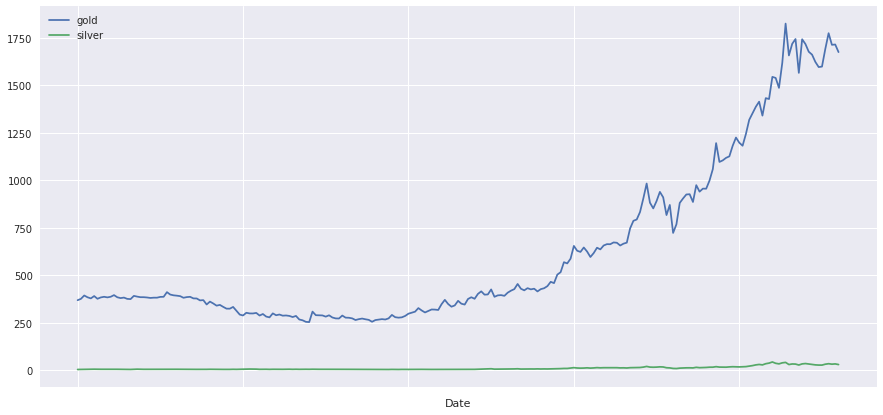

In [4]:
data[['gold', 'silver']].plot();

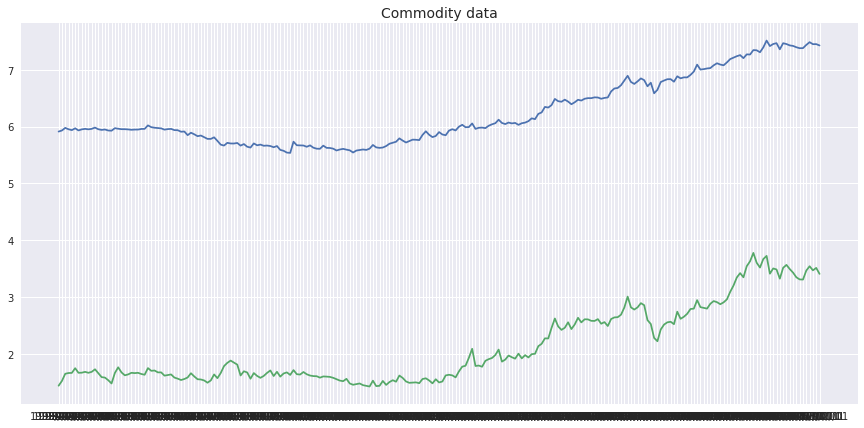

In [5]:
plt.plot(np.log(data.gold), label='log(gold)')
plt.plot(np.log(data.silver), label='log(silver)')
plt.title('Commodity data', fontsize='14')
plt.show()

## 2. Data preparation

In [6]:
# function to prepare x and y variable
# for the univariate series
def prepare_data(df, steps=1):
    temp = df.shift(-steps).copy()
    y = temp[:-steps].copy()
    X = df[:-steps].copy()
    return X, y

In [7]:
gold_X, gold_y = prepare_data(np.log(data[['gold']]), steps=1)
silver_X, silver_y = prepare_data(np.log(data[['silver']]), steps=1)

len(gold_X), len(gold_y), len(silver_X), len(silver_y)

(230, 230, 230, 230)

In [8]:
X = pd.concat([gold_X, silver_X], axis=1)
y = pd.concat([gold_y, silver_y], axis=1)

In [9]:
X.head()

,gold,silver
Date,,
1993/11/01,5.911474,1.446919
1993/12/01,5.930387,1.530395
1994/01/01,5.976351,1.656321
1994/02/01,5.951944,1.669592
1994/03/01,5.936876,1.671473


In [10]:
y.head()

,gold,silver
Date,,
1993/11/01,5.930387,1.530395
1993/12/01,5.976351,1.656321
1994/01/01,5.951944,1.669592
1994/02/01,5.936876,1.671473
1994/03/01,5.968708,1.754404


In [11]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=seed, shuffle=False)

print('Training and test data shape:')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training and test data shape:


((218, 2), (218, 2), (12, 2), (12, 2))

In [12]:
timesteps = 1
features = X_train.shape[1]
xavier = initializers.glorot_normal()

X_train = np.reshape(X_train.values, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test.values, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218, 1, 2), (12, 1, 2), (218, 2), (12, 2))

## 3. Model building

In [13]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv, y_test_inv = np.exp(y_train), np.exp(y_test)
    y_train_pred_inv, y_test_pred_inv = np.exp(y_train_pred), np.exp(y_test_pred)
    
    # MAE and NRMSE calculation for gold
    y_train_gold = y_train_inv.values[:, 0]
    y_train_pred_gold = y_train_pred_inv[:, 0]  
    y_test_gold = y_test_inv.values[:, 0]
    y_test_pred_gold = y_test_pred_inv[:, 0]
    
    train_rmse_g = np.sqrt(mean_squared_error(y_train_gold, y_train_pred_gold))
    train_mae_g = np.round(mean_absolute_error(y_train_gold, y_train_pred_gold), 3)
    train_nrmse_g = np.round(train_rmse_g/np.std(y_train_gold), 3)

    test_rmse_g = np.sqrt(mean_squared_error(y_test_gold, y_test_pred_gold))
    test_mae_g = np.round(mean_absolute_error(y_test_gold, y_test_pred_gold), 3)
    test_nrmse_g = np.round(test_rmse_g/np.std(y_test_gold), 3)
    
    print('Training and test result for gold:')
    print(f'Training MAE: {train_mae_g}')
    print(f'Trainig NRMSE: {train_nrmse_g}')
    print(f'Test MAE: {test_mae_g}')
    print(f'Test NRMSE: {test_nrmse_g}')
    print()
    
    
    # MAE and NRMSE calculation for silver
    y_train_silver = y_train_inv.values[:, 1]
    y_train_pred_silver = y_train_pred_inv[:, 1]
    y_test_silver = y_test_inv.values[:, 1]
    y_test_pred_silver = y_test_pred_inv[:, 1] 
    
    train_rmse_s = np.sqrt(mean_squared_error(y_train_silver, y_train_pred_silver))
    train_mae_s = np.round(mean_absolute_error(y_train_silver, y_train_pred_silver), 3)
    train_nrmse_s = np.round(train_rmse_s/np.std(y_train_silver), 3)

    test_rmse_s = np.sqrt(mean_squared_error(y_test_silver, y_test_pred_silver))
    test_mae_s = np.round(mean_absolute_error(y_test_silver, y_test_pred_silver), 3)
    test_nrmse_s = np.round(test_rmse_s/np.std(y_test_silver), 3)

    print('Training and test result for silver:')
    print(f'Training MAE: {train_mae_s}')
    print(f'Trainig NRMSE: {train_nrmse_s}')
    print(f'Test MAE: {test_mae_s}')
    print(f'Test NRMSE: {test_nrmse_s}')
    
    return y_train_pred_inv, y_test_pred_inv

In [14]:
def model_training(X_train, X_test, y_train, model, batch=4, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

### LSTM - v1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 10.63 seconds
Training and test result for gold:
Training MAE: 90.478
Trainig NRMSE: 0.506
Test MAE: 554.369
Test NRMSE: 10.767

Training and test result for silver:
Training MAE: 2.726
Trainig NRMSE: 0.599
Test MAE: 13.157
Test NRMSE: 5.131


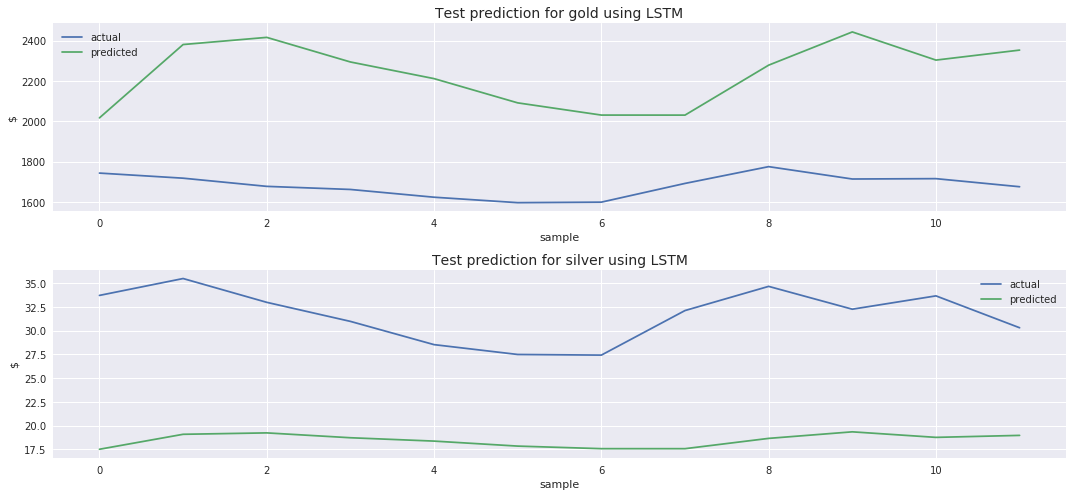

In [15]:
model = Sequential()
model.add(LSTM(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v1')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM - v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 3)              72        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 17.292 seconds
Training and test result for gold:
Training MAE: 466.597
Trainig NRMSE: 1.619
Test MAE: 1587.939
Test NRMSE: 29.878

Training and test result for silver:
Training MAE: 5.204
Trainig NRMSE: 1.028
Test MAE: 23.789
Test NRMSE: 9.18


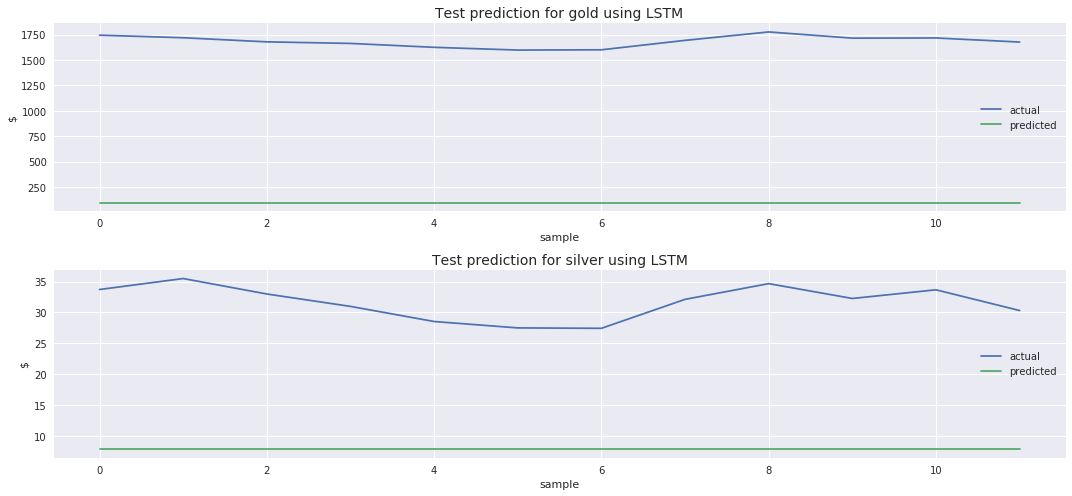

In [16]:
model = Sequential()

model.add(LSTM(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(LSTM(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v2')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM - v3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 5)              160       
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 19.443 seconds
Training and test result for gold:
Training MAE: 61.323
Trainig NRMSE: 0.212
Test MAE: 93.26
Test NRMSE: 2.119

Training and test result for silver:
Training MAE: 1.18
Trainig NRMSE: 0.262
Test MAE: 2.239
Test NRMSE: 0.954


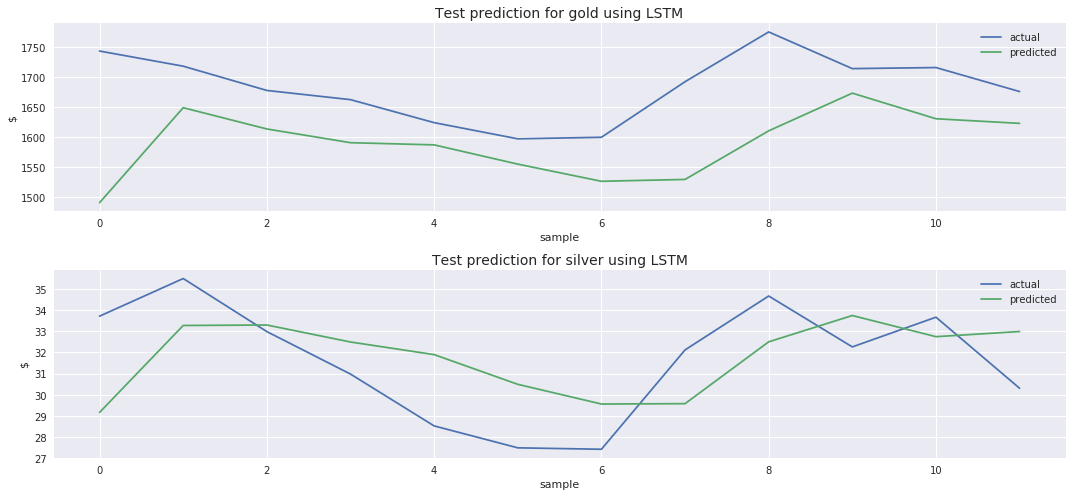

In [17]:
model = Sequential()

model.add(LSTM(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(LSTM(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v3')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 160       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 12.121 seconds
Training and test result for gold:
Training MAE: 99.141
Trainig NRMSE: 0.529
Test MAE: 550.932
Test NRMSE: 10.769

Training and test result for silver:
Training MAE: 2.205
Trainig NRMSE: 0.479
Test MAE: 10.299
Test NRMSE: 4.054


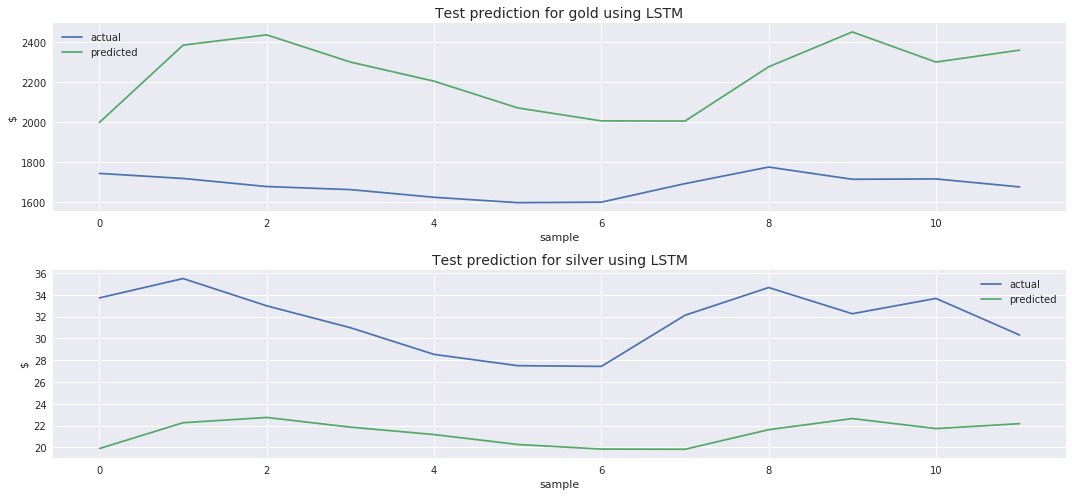

In [18]:
model = Sequential()

model.add(LSTM(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v4')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM - v5 (Final Model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 13.157 seconds
Training and test result for gold:
Training MAE: 33.316
Trainig NRMSE: 0.136
Test MAE: 69.977
Test NRMSE: 1.48

Training and test result for silver:
Training MAE: 0.914
Trainig NRMSE: 0.19
Test MAE: 2.644
Test NRMSE: 1.14


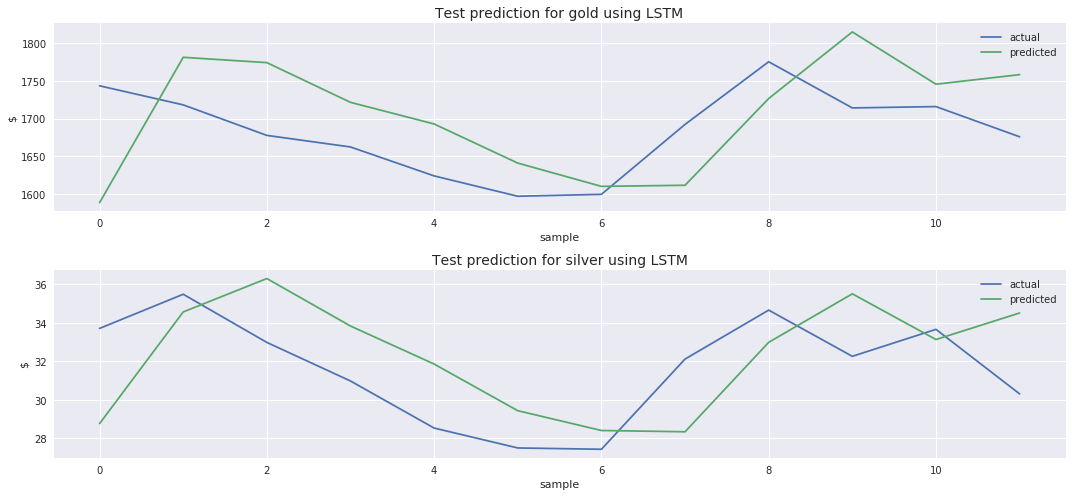

In [19]:
model = Sequential()

model.add(LSTM(10, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v5')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM - v6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7)                 280       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 16        
Total params: 296
Trainable params: 296
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 11.834 seconds
Training and test result for gold:
Training MAE: 466.862
Trainig NRMSE: 1.62
Test MAE: 1588.204
Test NRMSE: 29.883

Training and test result for silver:
Training MAE: 5.204
Trainig NRMSE: 1.028
Test MAE: 23.788
Test NRMSE: 9.18


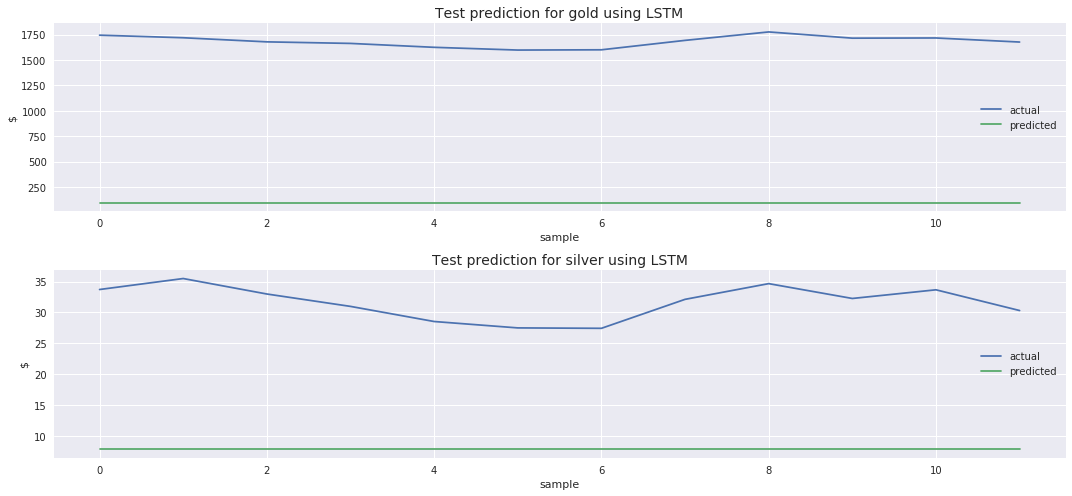

In [20]:
model = Sequential()

model.add(LSTM(7, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='LSTM-v6')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using LSTM', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using LSTM', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()